### Subsidization and participation in decentralized networks (bivariate time series analysis)

*An extended version of this analysis, conducted with data from different sources, is under peer review for the MIT journal Cryptoeconomic Systems. This notebook serves as a general open-source reference for the methodologies and code*. 

Decentralized networks are able to deliver foundational internet services (e.g. storage, access control, stateful operations, consensus) without the need for a trusted intermediary platform – a platform whose business model may align with unsavory practices such as privacy invasion, personal data hoarding, copying third-party products, self-favoring in search results, promoting misinformation, etc.  

Many decentralized networks function through the efforts of a distributed, pseudonymous group of service-providers who collectively provide the network's specialized internet service. They also collectively own and control the network, making it *decentralized*! A popular mechanism to make pseudonymous actors behave in the network's interests – i.e. by providing a high-quality and reliable service – involves locking collateral up-front ('staking'). A related and critical mechanism is the regular provision of subsidies to service-providers, which **secures their availability before the service is widely adopted and paid for**, thereby addressing the chicken-and-egg/cold start/critical mass dilemma faced by virtually all two-sided (digital) markets.   

Using a 'decentralized Uber' as an analogue to explain these two mechanisms, the *collateral* would be a sum of capital a driver submits to be locked, which would be forfeited if they provably misbehaved or failed to turn up after agreeing to. In this analogy, the *subsidy* would be a variable cash payment to drivers who are provably available for riders, regardless of how many rides they actually fulfil. Indeed, Uber and Lyft still have subsidy schemes.

The total collateral committed to the decentralized network's 'protocol' by service-providers is called the “participation rate” – more or less the total capacity offered by the supply side of the market. Ideally it is kept within acceptable bounds. Too low, and the security, availability and differentiating utility of the network all suffer (imagine Uber with only a few drivers per city). Too high, and the subsidy budget is stretched thin. In some networks, high participation also leads to a lack of native token liquidity – i.e. the amount of currency in free circulation – which makes it harder to actually _use_ the network (this is a much looser analogy, but imagine an Uber where diluted subsidy income breaks the app's payment feature). 

In many prominent decentralized networks, the **subsidy mechanism** is tasked with **regulating the participation rate within acceptable bounds**. Many subsidy models are designed wit the implicit assumption that the participation in a given moment is a function of the subsidy’s real value in a preceding moment. Service-providers are **expected to react to changes in subsidy revenue by adjusting their total committed collateral and capacity to serve**. In other words, if the subsidy goes down, total participation is supposed to go down too. This sort of makes sense – if you started paying Uber drivers a smaller subsidy per day, you'd probably get fewer turning up. 

This notebook seeks to investigate, in prominent networks (Tezos, Cosmos & Livepeer), the historical relationship between the real subsidy value and participation rate through bivariate time series analysis. The analysis utilizes stationarized time series data, evaluating the influence of the predicting feature (subsidy) on the target value (participation) over a range of time-lags (0-250 days).

Tangentially, analysis of service-provider behavior in decentralized networks may be valuable beyond the so-called ‘blockchain world’. The raw data is public, incorruptible and complete – unlike the equivalent data sets belonging to a large digital platform, it is not selectively published based on PR requirements. In decentralized networks, the economic incentives in question are non-trivial, given subsidy pay-outs in the region of $100s of millions. Finally, given that there is a general lack of theory that helps predict how subsidy model design affects economic outcomes (e.g. for encouraging electric vehicle or solar panel adoption), decentralized networks may a fertile ground for both empirical and analytical research.

In [202]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
from scipy import stats

from sklearn.linear_model import LinearRegression
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import kendalltau, pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests

In this notebook we wil analyse the decentralized networks **Tezos**, **Cosmos** and **Livepeer**. The protocols governing these networks epitomize the collateral/subsidy approach described above. They are also prominent, respected and, as of Oct 19th 2020, their appoximate market caps are 1.7bn, 1.4bn and $45m respectively (all USD). You can find out more about each network, their value propositions and protocol/economic design here: 
- https://tezos.com/
- https://cosmos.network/
- https://livepeer.org/primer

In [203]:
networks = {}
networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

networks['tezos'].head()

,real_yield,staking_rate
timestamp,,
2020-09-14 00:21:23.807455,0.01233,0.79117
2020-09-13 23:21:33.053643,0.01233,0.79118
2020-09-12 23:21:50.740596,0.01234,0.79099
2020-09-11 23:21:24.719743,0.01235,0.79103
2020-09-10 23:21:19.009697,0.01234,0.79113


We have three datasets at our disposal, one for each network. Each dataset contains a **real yield** column, a **staking rate** column, and a time/date index. 
- Tezos: 348 entries, from 2019-07-27 to 2020-09-14 (67 missing days)
- Cosmos: 189 entries, from 2019-07-27 to 2020-02-07 (6 missing days)
- Livepeer: 358 entries, from 2019-09-23 to 2020-09-14 (0 missing days)

The data sets are imperfect, however there is nothing to suggest that missing entries are biased in favour of any one conclusion; they appear to be due to arbitrary data loss. Nor is non-uniform row length an issue given that we are not directly comparing the networks.

Before diving into data transformation and analysis, let's make sure we understand how the subsidy is generated and distributed.

We're already comfortable with the **staking rate** concept– the overall percentage of tokens staked of the total supply, on a given day. This is equivalent to collateral, the locking of which implies committment to the duties of a service-provider [1]. This statistic is known as the 'participation rate' or 'staking ratio' elsewhere.

Subsidies are generated through 'inflation'. In decentralized networks, this term describes the programmatic growth of the native token's circulating supply [2]. Newly minted tokens are exclusively distributed to active service-providers to subsidize their operations and attract/maintain participation. Specifically, 'inflation' describes a *nominal* growth rate – the annual rate at which new tokens are minted, relative to the supply at that time [3] – as opposed to the actual value of the subsidy received. However, inflation is the main parameter that protocol designers have the power to tune. 

The actual value of the subsidy is closer to the next term; the 'yield'. The yield is the percentage a service-provider hypothetically gains annually on their locked collateral, given a certain staking rate. Generally, the greater the staking rate, the lower the yield – there's less to go round!

Finally, the **real yield** is the *actual* annual gain made by actively staking service-providers, taking into account the fact that staker income is also diluted by changes to the circulating supply. This is also computed as a percentage of the locked collateral, and is calculated as follows: 

$$ Real Yield = \frac{(1 + Yield)}{(1 + Inflation)}- 1 $$


To reiterate, the objective of this notebook is to understand the relationship, if any, between:

(1) Subsidization: the variable true value of a subsidy receieved by service-providers. This is the **real yield** column.

(2) Participation: the subsequent, collective decision by service-providers to increase, decrease or maintain the size of their locked tokens, which is expressed as a percentage of the total number of circulating tokens. This is the **staking rate** column.

To give us a sense of how the participation rate has varied historically, let's generate a simple time series graph. 

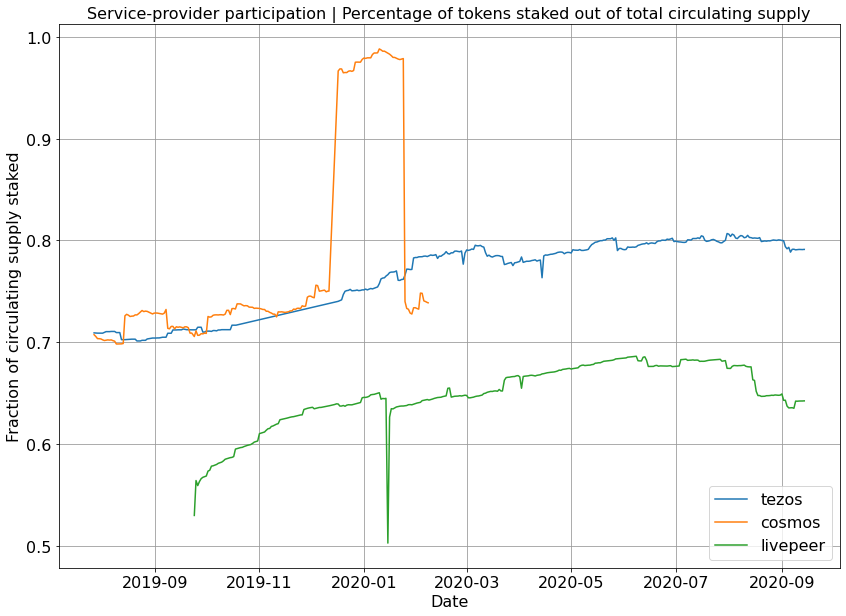

In [204]:
for net in networks:
    plt.plot(networks[net]['staking_rate'], label=net)
plt.title('Service-provider participation | Percentage of tokens staked out of total circulating supply', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Fraction of circulating supply staked', fontsize=16)
plt.grid(b=True, which='major', color='#999999', linestyle='-')
plt.legend(loc=4, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0], fig_size[1] = 14,10

We can see that the three time series under examination exhibit time-dependent/trending structure in their raw form, and hence are almost certainly non-stationary. Next, we'll test for autocorrelation. To do so, we will create a class that also will help us test the efficacy of our stationarization efforts later.

In [205]:
class TestStationarize():
    
    def __init__(self, df):
        self.df = df
        
    def adftest(self):
        output = {}
        output['network'] = self.df
        for col in self.df:        
            adf = adfuller(self.df[col])
            output = pd.Series(adf[0:2], index=['test_statistic','p_value'])
            for key,value in adf[4].items():
                output['critical_value (%s)'%key] = value
            if output['test_statistic'] <= output['critical_value (5%)'] and output['p_value'] <= 0.05:
                output['Null Hypothesis'] = 'Reject'
            else:
                output['Null Hypothesis'] = 'Accept'
            output['column'] = col
            return output

    def auto_corr(self):
        for col in self.df:
            col.autocorr(lag=5)
    
    def acf_plot(self):
        for col in self.df:
            plot_acf(self.df[col], lags=20, label=[col])
            plt.legend()        

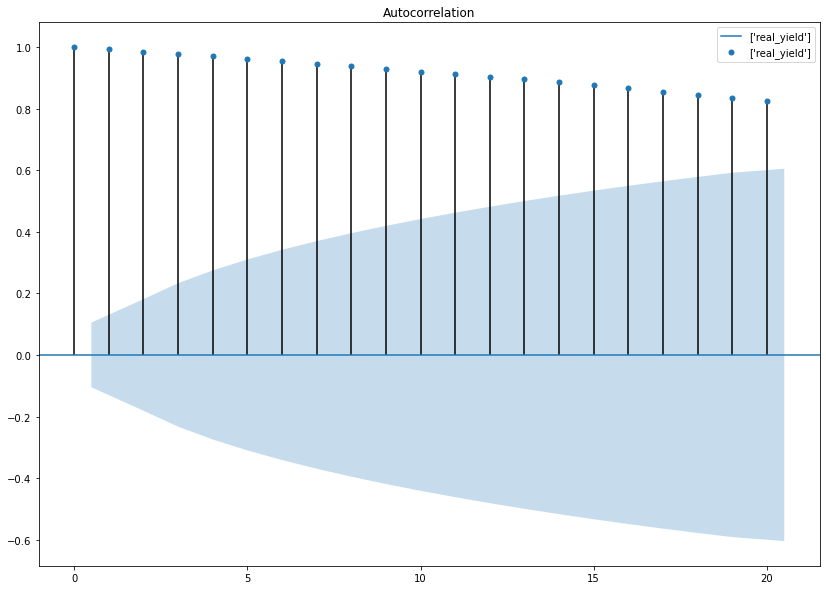

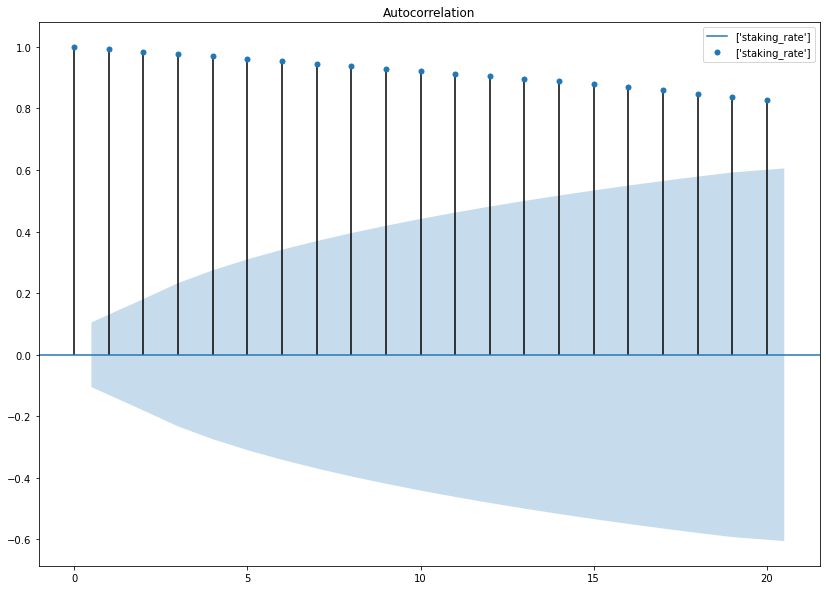

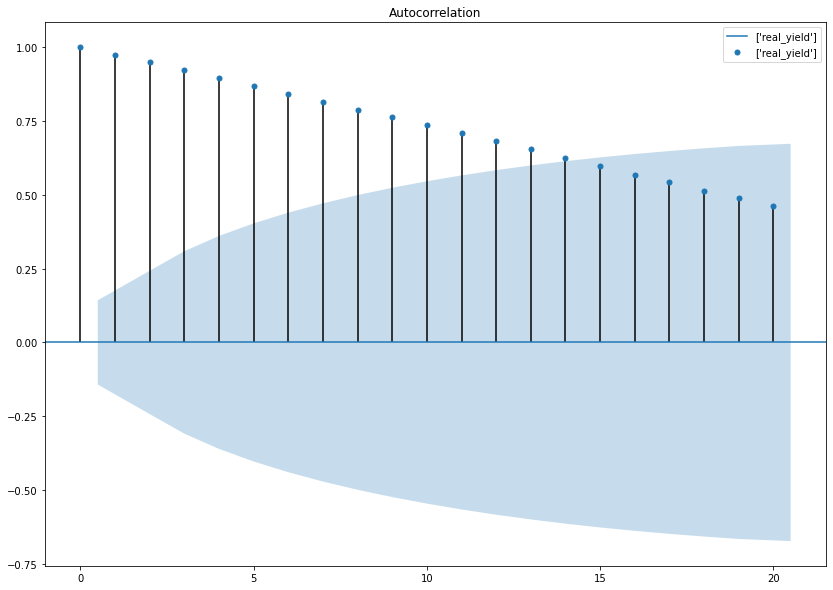

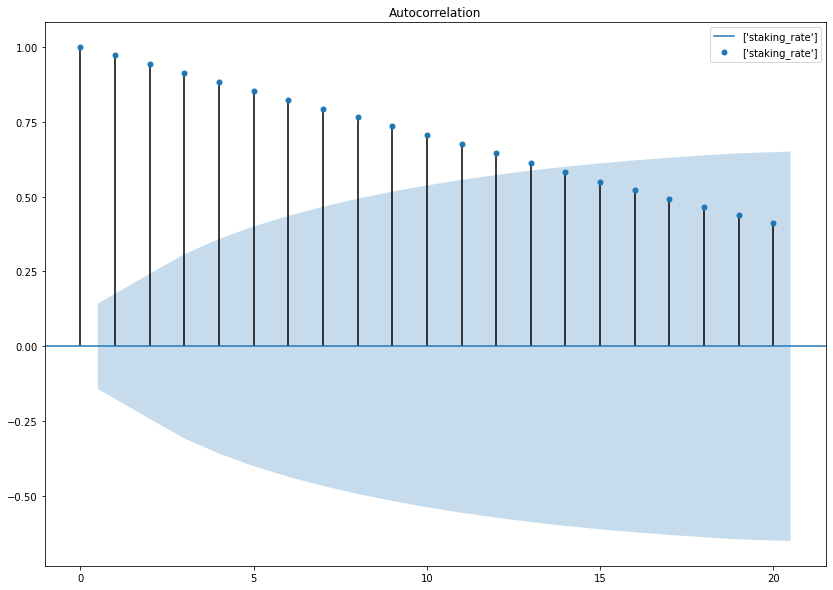

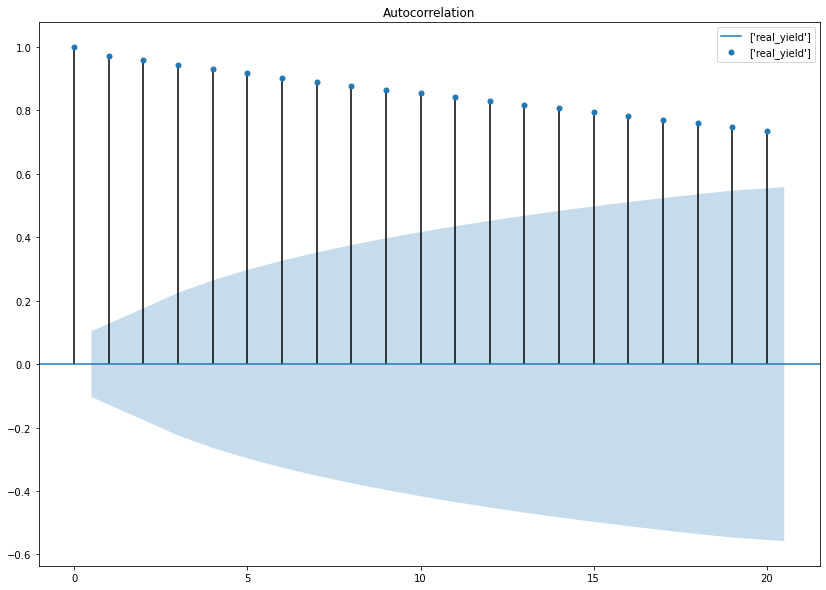

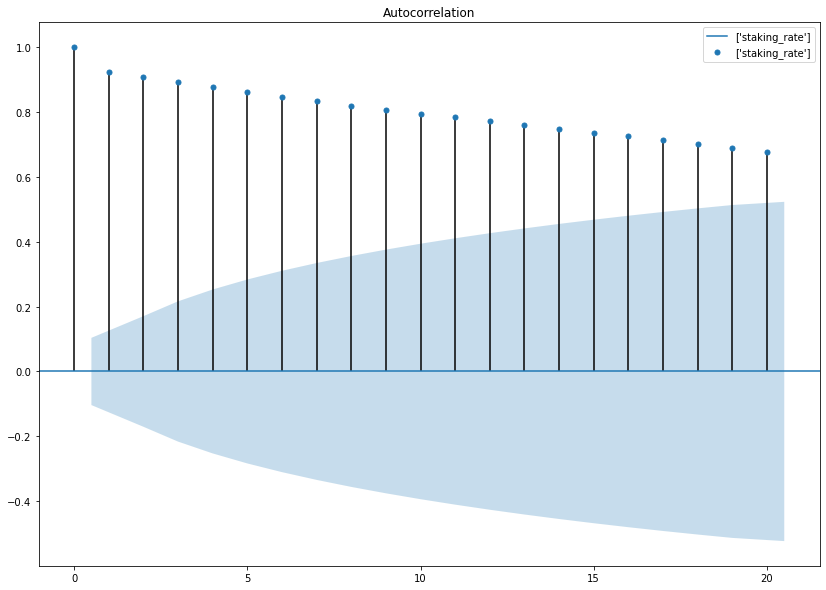

In [206]:
networks = {}
networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate'])
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate'])
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate'])

for net in networks:
    t_st = TestStationarize(networks[net])
    t_st.acf_plot()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 7
fig_size[1] = 5

We can see that all six time series are also strongly correlated with themselves. In Tezos's case, even a time lag of 20 days shows positive correlations of greater than 0.8. Though fairly common in time series data, this lack of stationarity (both time-dependency and autocorrelation) renders the results of biariate analyses, including Pearson cross-correlations and Granger predictive causality tests, far less meaningful. This because it is impossible to isolate the correlation coefficients that are a result of a genuine pairwise relationship, as opposed to a relationship between the time series and itself.

Non-stationarity can be remedied with data transformation techniques, contained in our next class CleanStationarize() below. The first transformation step is detrending, which involves generating a linear regression of the time series, then subtracting this trendline from the data. This reduces the time-dependency of the series. The next transformation step is differencing, which reduces the autocorrelation of the data.

Before transforming the data, we'll run our final, decisive statistical test to confirm non-stationarity – the Augmented Dickey-Fuller test. We can then perform this check on the data post-transformation, to see if we were successful. In the standard ADF test, the *null hypothesis* is that the time series has a unit root. If we fail to reject the null hypothesis, then the time series is non-stationary. We may fully reject the null hypothesis if the *p-value* less than or equal to 0.05 and the test statistic is less than or equal to the *critical value*. We accept a confidence interval of 5%. 

In [207]:
networks = {}
networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['staking_rate'])
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['staking_rate'])
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['staking_rate'])

adf_results = {}
for net in networks:
    networks[net] = networks[net].dropna()
    t_st = TestStationarize(networks[net])
    adf_results[net] = t_st.adftest()
adf_results

{'tezos': test_statistic              0.473236
 p_value                     0.984037
 critical_value (1%)         -3.44939
 critical_value (5%)         -2.86993
 critical_value (10%)        -2.57124
 Null Hypothesis               Accept
 column                  staking_rate
 dtype: object,
 'cosmos': test_statistic              -1.54196
 p_value                     0.512661
 critical_value (1%)         -3.46562
 critical_value (5%)         -2.87704
 critical_value (10%)        -2.57503
 Null Hypothesis               Accept
 column                  staking_rate
 dtype: object,
 'livepeer': test_statistic               1.53664
 p_value                     0.997654
 critical_value (1%)         -3.44906
 critical_value (5%)         -2.86979
 critical_value (10%)        -2.57116
 Null Hypothesis               Accept
 column                  staking_rate
 dtype: object}

As expected, for the *staking rate* time series for all three networks, we must accept the Null Hypothesis. For brevity the equivalent test for the *real yield* is not shown here, but the same result (accepting the Null Hypothesis) is produced for all three networks. 

We now perform some simple data transformation techniques, through the Class CleanStationarize, in an attempt to make the data more useful for analysis.

In [208]:
class CleanStationarize():
    def __init__(self, df):
        self.df = df
        
    def date(self):
        self.df['timestamp'] = self.df['timestamp'].str[0:10]
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'], format='%Y%m%d')
        self.df['timestamp'] = self.df.set_index('timestamp')
        
    def ipl(self):
        for column in self.df:
            self.df[column] = self.df[column].interpolate(method = 'linear', limit_direction = 'both')
    
    def detrend(self):
        for column in self.df:
            days = [i for i in range(0,len(self.df[column]))]
            days = np.reshape(days, (len(days), 1))
            model = LinearRegression()
            col_values = self.df[column]
            model.fit(days, self.df[column])
            col_trend = model.predict(days)
            detrended_col_values = [col_values[i] - col_trend[i] for i in range(0, len(self.df[column]))]
            self.df[column] = detrended_col_values
    
    def diff(self):
        for column in self.df:
            self.df[column] = self.df[column].diff(periods=-1)

In [209]:
networks = {}

networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

adf_d = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].dropna()
    t_st = TestStationarize(networks[net])
    adf_d[net] = t_st.adftest()
adf_d

{'tezos': test_statistic              -22.2861
 p_value                            0
 critical_value (1%)         -3.44939
 critical_value (5%)         -2.86993
 critical_value (10%)        -2.57124
 Null Hypothesis               Reject
 column                  staking_rate
 dtype: object,
 'cosmos': test_statistic              -13.3676
 p_value                   5.2743e-25
 critical_value (1%)         -3.46581
 critical_value (5%)         -2.87712
 critical_value (10%)        -2.57508
 Null Hypothesis               Reject
 column                  staking_rate
 dtype: object,
 'livepeer': test_statistic              -13.3685
 p_value                   5.2539e-25
 critical_value (1%)         -3.44901
 critical_value (5%)         -2.86976
 critical_value (10%)        -2.57115
 Null Hypothesis               Reject
 column                  staking_rate
 dtype: object}

In [270]:
# Validate the ADF test with random data. We expect this to return as stationary. 
df_rand = pd.DataFrame(np.random.randint(0,100, size=(200, 2)), columns=list('AB'))
t_st = TestStationarize(df_rand)
adf_d = t_st.adftest()
adf_d.head(10)

test_statistic            -13.0329
p_value                 2.3252e-24
critical_value (1%)       -3.46364
critical_value (5%)       -2.87618
critical_value (10%)      -2.57457
Null Hypothesis             Reject
column                           A
dtype: object

In [210]:
networks = {}

networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield',  'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'timestamp'],index_col='timestamp', parse_dates=True)

adf_d = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].dropna()
    t_st = TestStationarize(networks[net])
    adf_d[net] = t_st.adftest()
adf_d

{'tezos': test_statistic            -21.7315
 p_value                          0
 critical_value (1%)       -3.44939
 critical_value (5%)       -2.86993
 critical_value (10%)      -2.57124
 Null Hypothesis             Reject
 column                  real_yield
 dtype: object,
 'cosmos': test_statistic             -13.4751
 p_value                 3.32372e-25
 critical_value (1%)        -3.46581
 critical_value (5%)        -2.87712
 critical_value (10%)       -2.57508
 Null Hypothesis              Reject
 column                   real_yield
 dtype: object,
 'livepeer': test_statistic             -15.5522
 p_value                 2.09298e-28
 critical_value (1%)        -3.44896
 critical_value (5%)        -2.86974
 critical_value (10%)       -2.57114
 Null Hypothesis              Reject
 column                   real_yield
 dtype: object}

We can see that for all six time series, we have transformed the data enough to be able to reject the Null Hypothesis, which suggets the data is sufficiently stationarized. This means that any pairwise relationships we extract will not be obfuscated by time-dependency or autocorrelation. 

We now proceed to construct a Class for analysing the relationship between the subsidy value (real yield) and participation (staking rate). We are interested in the *reaction* of service-providers to a variable subsidy, so we must institute a range of time lags between the feature (or 'predictor') and the target. We will apply (1) Pearson cross-correlation and (2) Granger Predictive Causality analysis to better understand the relationship between the time series. For the former, we will also compute corresponding p-values to help interpret the significance of any strong cross-correlations. 

In [257]:
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

In [258]:
class LaggedRelationship():
    def __init__(self, df, lag_start, lag_end, feature, target, resample):
        self.df = df
        self.lag_start = lag_start
        self.lag_end = lag_end
        self.feature = feature 
        self.target = target
        self.resample = resample
    
    def lag_cross_corr(self):
        df_temp = pd.DataFrame()
        cc = {}
        for i in range(self.lag_start, self.lag_end):
            df_temp[self.feature] = self.df[self.feature].shift(i)
            df_temp = df_temp.dropna()
            cc[i*self.resample] = df_temp[self.feature].corr(self.df[self.target])
            df_temp[self.feature] = self.df[self.feature]
        return cc
    
    def lag_cc_pv(self):
        df_temp = pd.DataFrame()
        p_values = {}
        for i in range(self.lag_start, self.lag_end):
            df_temp[self.feature] = self.df[self.feature].shift(i)
            df_temp = df_temp.dropna()
            p_values[i*self.resample] = df_temp[self.feature].corr(self.df[self.target], method=pearsonr_pval)
            df_temp[self.feature] = self.df[self.feature]
        return p_values
    
    def SSR_F_causality(self):
        maxlag = self.lag_end - self.lag_start  
        lag_SSR = {}
        results = grangercausalitytests(self.df[[self.target, self.feature]], maxlag, verbose=False)
        for i in range(0, maxlag):
            p_value = results[i+1][0]['ssr_ftest'][1]
            lag_SSR[i*self.resample] = p_value
        return lag_SSR

Let's also make it easier to graph the results.

In [212]:
def visualize(dic, label):
    for i in dic:
        plt.plot(*zip(*sorted(dic[i].items())), label = i+'_'+label, alpha=0.9, marker='o')
    plt.xlabel('Lag: # of days elapsed between 1) Real Yield & 2) Staking Rate data entries', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=16)
    plt.grid(b=True, which='major', color='#999999', linestyle='-')
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 14
    fig_size[1] = 10

The first bivariate analysis we'll conduct is a test for _granger predictive causality_ (GPC). To be clear, evidence of GPC do not imply general causality. Rather, Granger tests evaluate the extent to which a series A (here, the real yield) _lowers_ the prediction error of a series Y (here, the staking rate) if it is included in a larger model. Another way to think about it: if the real yield time series provides extra information regarding the distribution of future values of the staking rate, that are _not already contained in the past values of the participation rate_, then the relationship involves GPC.

Before performing this test, we'll stationarize the data using the methods we know are effective. We'll start by applying this to data that has been downsampled to various durations. Our raw data is daily, which we will also produce results for. 

We'll use the 7-day sum for the real yield, since stakers can only accumulate rewards through the subsidy mechanism. We'll use the 7-day mean for the participation rate.

In [213]:
networks = {}

networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

ssr_w = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].resample('W').agg(dict(real_yield='sum', staking_rate='mean'))
    networks[net] = networks[net].dropna()
    lr = LaggedRelationship(networks[net], 0, 7,'real_yield', 'staking_rate', 7)
    ssr_w['%s_ssr'%net] = lr.SSR_F_causality()
ssr_w

{'tezos_ssr': {0: 0.5421456670509278,
  7: 0.7092995985664701,
  14: 0.7863578764904765,
  21: 0.8330861502903623,
  28: 0.8164399030643873,
  35: 0.943503934235058,
  42: 0.7280251341781256},
 'cosmos_ssr': {0: 0.5541475055488511,
  7: 0.6402447504379855,
  14: 0.6313230388610793,
  21: 0.8014373369960165,
  28: 0.1570722322260121,
  35: 0.24785463832203217,
  42: 0.3206193539306034},
 'livepeer_ssr': {0: 0.0775941583764142,
  7: 0.28591425537231274,
  14: 0.6811073665465747,
  21: 0.44612767461461034,
  28: 0.42900532941657366,
  35: 0.47920385356695794,
  42: 0.49427021860992626}}

Text(0, 0.5, 'Predictive Causality (Granger)')

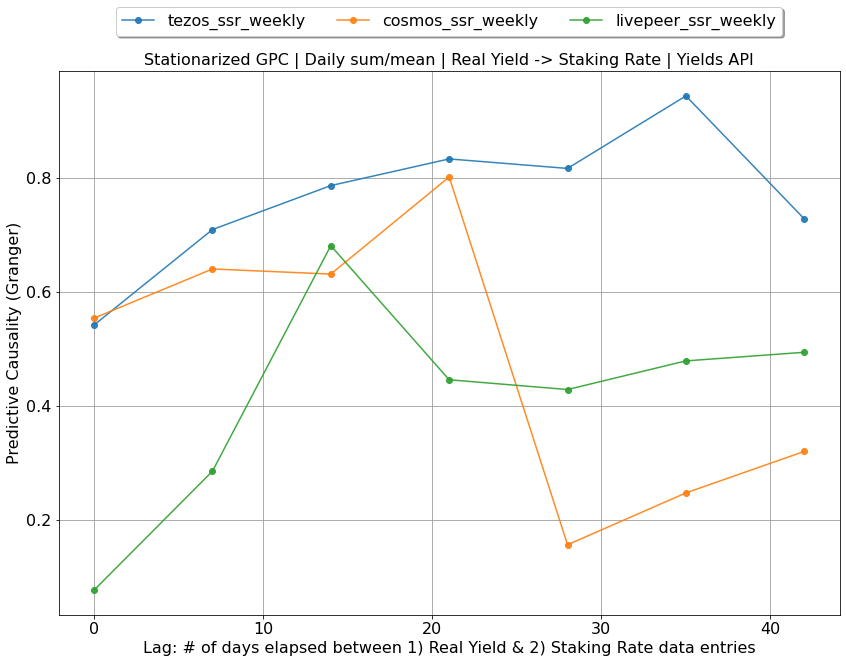

In [232]:
visualize(ssr_w, 'weekly')
plt.title('Stationarized GPC | Daily sum/mean | Real Yield -> Staking Rate | Yields API', fontsize=16)
plt.ylabel('Predictive Causality (Granger)', fontsize=16)
#plt.axis([0, 6, 0,0.5])
#plt.yscale('log')

No notable results so far as all fall above the threshold of statistical significance (p > 0.05). 

Now we'll perform the same test on the raw data (daily) and data downsampled to fortnightly (two data points per month).

In [215]:
networks = {}

networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

ssr_d = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].dropna()
    lr = LaggedRelationship(networks[net], 0, 43,'real_yield', 'staking_rate', 1)
    ssr_d['%s_ssr'%net] = lr.SSR_F_causality()

In [216]:
networks = {}

networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

ssr_fn = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].resample('SMS').agg(dict(real_yield='sum', staking_rate='mean'))
    networks[net] = networks[net].dropna()
    lr = LaggedRelationship(networks[net], 0, 4,'real_yield', 'staking_rate', 14)
    ssr_fn['%s_ssr'%net] = lr.SSR_F_causality()

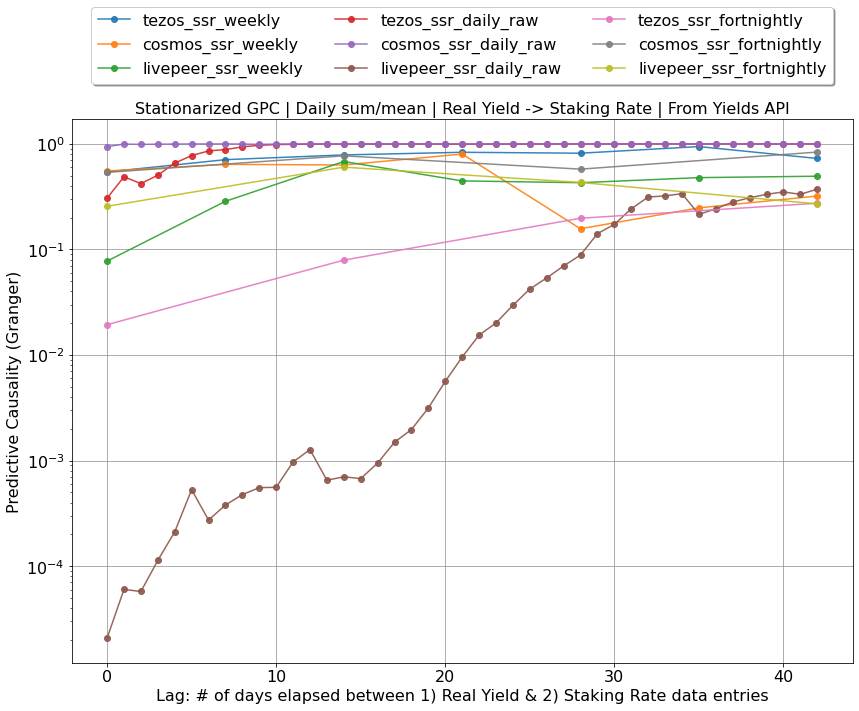

In [217]:
visualize(ssr_w, label='weekly')
visualize(ssr_d, label='daily_raw')
visualize(ssr_fn, label='fortnightly')
plt.title('Stationarized GPC | Daily sum/mean | Real Yield -> Staking Rate | From Yields API', fontsize=16)
plt.ylabel('Predictive Causality (Granger)', fontsize=16)
#plt.axis([0, 6, 0,0.5])
plt.yscale('log')

Of all the networks and downsample durations, only the relationship between real yield and staking rate with **daily Livepeer** data produced any evidence of Granger predictive causality (p < 0.05). Here, we see that each lag between 1 and 25 days generates a GPC result of less than or equal to 0.05. This may be statistically significant – we will seek corroboration with the next analysis. It's also worth noting that the other networks and time lags did _not_ produce any evidence of GPC.

Next, we will perform a similar bivariate analysis using standard Pearson cross-correlation. Note that we deliberately limit the maximum time-lag to 91 days (14 weeks), since this is approximately half the total length of the Cosmos dataset. At time lags of >150, the Cosmos results zig-zag between strongly positive and negative correlations, but these results are based on a very small sample (<40 entries) and are therefore not very useful.

In [250]:
networks = {}
networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

cc_w = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].resample('W').agg(dict(real_yield='sum', staking_rate='mean'))
    lr = LaggedRelationship(networks[net], 0, 14, 'real_yield', 'staking_rate', 7)
    cc_w['%s_cc'%net] = lr.lag_cross_corr()
cc_w

{'tezos_cc': {0: -0.9718258910782496,
  7: -0.03380376073299609,
  14: -0.00344386170450533,
  21: -0.18753691766140762,
  28: -0.06003802803843594,
  35: -0.04286466013378558,
  42: -0.14552408336862357,
  49: -0.006369026873290868,
  56: -0.00937758623260363,
  63: 0.09527497034339866,
  70: -0.020324062518200157,
  77: -0.1682707168396378,
  84: 0.3245128708333697,
  91: 0.18820078064504475},
 'cosmos_cc': {0: -0.9970106108846748,
  7: -0.0027029528987714832,
  14: -0.055550025132012563,
  21: -0.021647748695389997,
  28: 0.0333082315685835,
  35: 0.7312062567358304,
  42: -0.0058492734527004035,
  49: 0.07103354363673017,
  56: 0.2365933328648898,
  63: -0.049145748845503066,
  70: 0.014866992318745754,
  77: -0.4034734834912955,
  84: -0.06992993819812483,
  91: 0.01991687417464041},
 'livepeer_cc': {0: -0.8550886873224909,
  7: -0.39386743061012314,
  14: -0.27902392924279684,
  21: -0.2986352568011409,
  28: -0.20414923752306238,
  35: -0.35371725261883147,
  42: -0.248702428381

Text(0, 0.5, 'Cross-correlation (Pearson)')

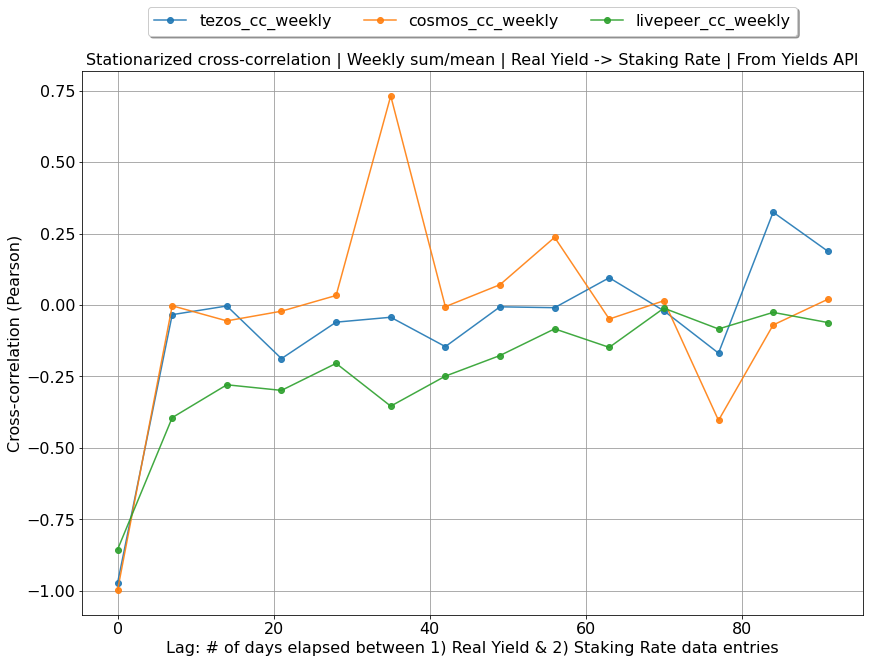

In [251]:
visualize(cc_w, label='weekly')
plt.title('Stationarized cross-correlation | Weekly sum/mean | Real Yield -> Staking Rate | From Yields API', fontsize=16)
plt.ylabel('Cross-correlation (Pearson)', fontsize=16)

This graph displays the Pearson cross-correlation coefficient for the real yield and staking rate time series, with the latter lagged by 0 - 200 days. Since the data is downsampled to weekly, this step of 7 days also applies to the lag – so we are looking at 28 results, each a weekly lag increment. We maintain the x-axis unit as days for more intuitive comparison with other downsample durations.

Now, we'll perform the same test on the raw data (daily) and data downsampled to fortnightly (two data points per month). This time we'll also downsample to monthly data.

In [246]:
networks = {}

networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

cc_d = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].resample('D').agg(dict(real_yield='sum', staking_rate='mean'))
    lr = LaggedRelationship(networks[net], 0, 91, 'real_yield', 'staking_rate', 1)
    cc_d['%s_cc'%net] = lr.lag_cross_corr()    
cc_d

{'tezos_cc': {0: -0.9902662493132012,
  1: 0.1658851147475421,
  2: 0.0067486899933212495,
  3: -0.10544346663400166,
  4: -0.022710144117307526,
  5: 0.014781914202786762,
  6: -0.013088827050353755,
  7: 0.008671195501087178,
  8: -0.007242652359503681,
  9: 0.019150816230266394,
  10: 0.040400039953747836,
  11: -0.050026278126200925,
  12: 0.09685593051481839,
  13: -0.046888196010314645,
  14: -0.017696435663536438,
  15: -0.0523546056002138,
  16: 0.028582083828959475,
  17: -0.035346843453714465,
  18: 0.02653807084305983,
  19: -0.023284082118873235,
  20: 0.013947073205455579,
  21: -0.03827374076784229,
  22: -0.06140666031488159,
  23: 0.05255951164520667,
  24: -0.07883775294920316,
  25: -0.036964720672008566,
  26: 0.005488528700049965,
  27: -0.017853304075445206,
  28: 0.00865462582273745,
  29: 0.0017842001993835406,
  30: -0.0593421216072245,
  31: 0.03197310351943147,
  32: -0.019577124020634832,
  33: -0.005705176842229634,
  34: 0.08789520740441091,
  35: 0.0341563

In [245]:
networks = {}

networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

cc_fn = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].resample('SMS').agg(dict(real_yield='sum', staking_rate='mean'))
    lr = LaggedRelationship(networks[net], 0, 7, 'real_yield', 'staking_rate', 15)
    cc_fn['%s_cc'%net] = lr.lag_cross_corr()    
cc_fn

{'tezos_cc': {0: -0.9645365017097778,
  15: -0.26845619316802577,
  30: -0.19793141259362573,
  45: 0.00680317769129625,
  60: -0.013541088834794783,
  75: 0.2054270788086072,
  90: 0.3090684552976108},
 'cosmos_cc': {0: -0.9962968850623748,
  15: -0.00018699715435981887,
  30: 0.7156723001286088,
  45: 0.02217104583761926,
  60: 0.15642469964682662,
  75: -0.43573401859431216,
  90: 0.2534245694282964},
 'livepeer_cc': {0: -0.9885146410359017,
  15: 0.4047946951547699,
  30: -0.056209204257261364,
  45: -0.016976595942762372,
  60: -0.024440853863811566,
  75: 0.08971905512994974,
  90: -0.015422234095031294}}

In [244]:
networks = {}

networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

cc_m = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].resample('M').agg(dict(real_yield='sum', staking_rate='mean'))
    lr = LaggedRelationship(networks[net], 0, 4, 'real_yield', 'staking_rate', 30)
    cc_m['%s_cc'%net] = lr.lag_cross_corr() 
cc_m

{'tezos_cc': {0: -0.9547092609454456,
  30: -0.3549758513448417,
  60: 0.04689973841876198,
  90: 0.18885041250260395},
 'cosmos_cc': {0: -0.9840293829885627,
  30: 0.4881607033050452,
  60: -0.10112404368639089,
  90: 0.7961847291051687},
 'livepeer_cc': {0: -0.7998207419750099,
  30: -0.6765712097421908,
  60: -0.3783241461093622,
  90: -0.21593394401426025}}

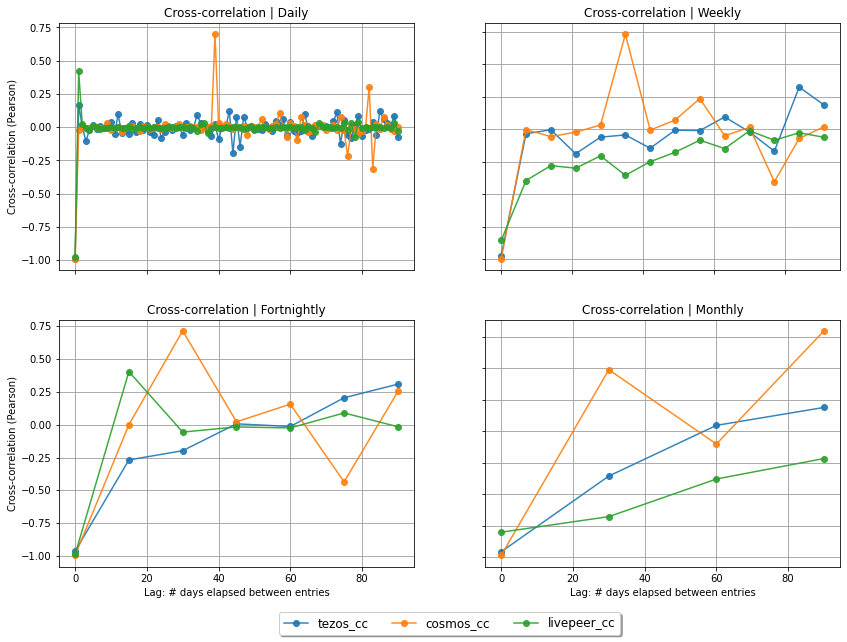

In [253]:
fig, axs = plt.subplots(2, 2)
for i in cc_d:
    axs[0, 0].plot(*zip(*sorted(cc_d[i].items())), label = i, alpha=0.9, marker='o')
    axs[0, 0].set_title('Cross-correlation | Daily')
for i in cc_w:
    axs[0, 1].plot(*zip(*sorted(cc_w[i].items())), label = i, alpha=0.9, marker='o')
    axs[0, 1].set_title('Cross-correlation | Weekly')
for i in cc_fn:
    axs[1, 0].plot(*zip(*sorted(cc_fn[i].items())), label = i, alpha=0.9, marker='o')
    axs[1, 0].set_title('Cross-correlation | Fortnightly')
for i in cc_m:
    axs[1, 1].plot(*zip(*sorted(cc_m[i].items())), label = i, alpha=0.9, marker='o')
    axs[1, 1].set_title('Cross-correlation | Monthly')
for ax in axs.flat:
    ax.set(xlabel='Lag: # days elapsed between entries', ylabel='Cross-correlation (Pearson)')
    ax.label_outer()
    ax.grid(b=True, which='major', color='#999999', linestyle='-')
ax.legend(loc='lower center', bbox_to_anchor=(-0.1,-0.3),
      ncol=3, fancybox=True, shadow=True, fontsize=12)

The most clear result occurs when the time-lag between the variables is zero. Here, the cross-correlation is almost invariably -1 (or very close), which hints at the presence of a strong inverse relationship between the real yield and and the staking rate. However, because at a lag of zero neither variable occurrs ‘first’, it isn't easy to conclude which way the causality might be. Having said that, we know that the subsidy mechansims of all three networks split a near-invariable sum of newly minted tokens amongst service-providers. So it is expected that there should be a nearly perfect inverse relationship, with the staking rate programmatically, predictably and instaneously driving the value of the real yield. 

What else do we see here? Mostly, the lack of meaningful cross-correlation coefficients (>±0.9). For the networks besides Cosmos, there is a slight tendency towards negative coefficients. The Cosmos results yield the greatest coefficient results: 

- _Daily_ at time lag of 39 days: 0.699
- _Weekly_ at time lag of 35 days: 0.731
- _Fortnightly_ at time lag of 30 days: 0.716
- _Monthly_ at time lag of 90 days: 0.796

Although this shows consistency across various downsamples, none of these results provide evidence of a relationship between the real yield and the staking rate, when the real yield data point 'occurs' first. Another way to think about this: the real yield data entries are one constituent of the reality in which subsequent (lagged) staking rate entries occur. While it is impossible to truly isolate the real yield amongst the myriad factors affecting a service-provider's (or delegator's) decision to modify their stake size (which collectively drives changes in the overall staking rate), the fluctuating real yield is _designed_ to influence this decision. If there is no meaningful cross-correlation 

For completeness sake we run a final analysis of the  p-values which correspond to the cross-correlation coefficients. This would be more important if we needed to validate the statistical significance of strong coefficients.  

In [259]:
networks = {}
networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

pv_w = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].resample('W').agg(dict(real_yield='sum', staking_rate='mean'))
    lr = LaggedRelationship(networks[net], 0, 14, 'real_yield', 'staking_rate', 7)
    pv_w['%s_cc'%net] = lr.lag_cc_pv()
    
networks = {}
networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

pv_d = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].resample('D').agg(dict(real_yield='sum', staking_rate='mean'))
    lr = LaggedRelationship(networks[net], 0, 91, 'real_yield', 'staking_rate', 1)
    pv_d['%s_cc'%net] = lr.lag_cc_pv()    

networks = {}
networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

pv_fn = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].resample('SMS').agg(dict(real_yield='sum', staking_rate='mean'))
    lr = LaggedRelationship(networks[net], 0, 7, 'real_yield', 'staking_rate', 15)
    pv_fn['%s_cc'%net] = lr.lag_cc_pv()
    
networks = {}
networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

pv_m = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].resample('M').agg(dict(real_yield='sum', staking_rate='mean'))
    lr = LaggedRelationship(networks[net], 0, 4, 'real_yield', 'staking_rate', 30)
    pv_m['%s_cc'%net] = lr.lag_cc_pv() 

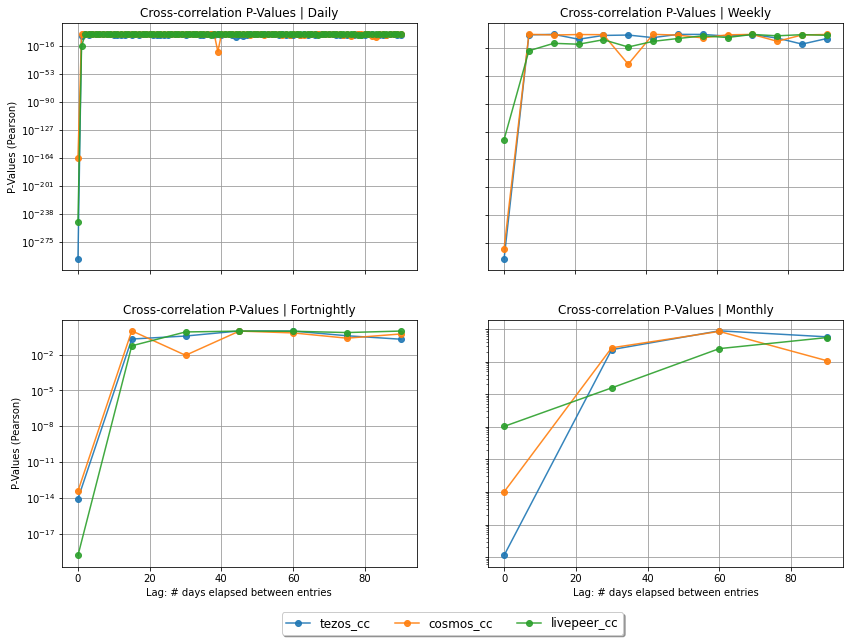

In [269]:
fig, axs = plt.subplots(2, 2)
for i in pv_d:
    axs[0, 0].plot(*zip(*sorted(pv_d[i].items())), label = i, alpha=0.9, marker='o')
    axs[0, 0].set_title('Cross-correlation P-Values | Daily')
for i in pv_w:
    axs[0, 1].plot(*zip(*sorted(pv_w[i].items())), label = i, alpha=0.9, marker='o')
    axs[0, 1].set_title('Cross-correlation P-Values | Weekly')
for i in pv_fn:
    axs[1, 0].plot(*zip(*sorted(pv_fn[i].items())), label = i, alpha=0.9, marker='o')
    axs[1, 0].set_title('Cross-correlation P-Values | Fortnightly')
for i in pv_m:
    axs[1, 1].plot(*zip(*sorted(pv_m[i].items())), label = i, alpha=0.9, marker='o')
    axs[1, 1].set_title('Cross-correlation P-Values | Monthly')
for ax in axs.flat:
    ax.set(xlabel='Lag: # days elapsed between entries', ylabel='P-Values (Pearson)')
    ax.label_outer()
    ax.grid(b=True, which='major', color='#999999', linestyle='-')
    ax.set_yscale('log')
ax.legend(loc='lower center', bbox_to_anchor=(-0.1,-0.3),
      ncol=3, fancybox=True, shadow=True, fontsize=12)

[1] The total collateral put up by service-providers includes capital delegated by passive token holders.

[2] Outside the blockchain world, inflation means rises in the national average price levels of goods/services. In the blockchain world, it refers to monetary supply growth. Clearly, no economists were consulted during the coining of this term. 

[3] Inflation can also occur for reasons other than the predictable minting of tokens through a subsidy schedule – for example, the release of locked tokens held by network-adjacent organizations, foundations or treasuries.